En este ejemplo vamos a tratar de generar imágenes similares a las del dataset de ropa FashionMNIST.

Pero esta vez lo váis a hacer vosotros :)

In [36]:
# importamos las librerías necesarias
import numpy as np
# buscad el dataset Fashion MNIST disponible en Keras e importadlo
# https://keras.io/datasets/
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
import matplotlib.pyplot as plt
from tensorflow import keras

In [22]:
# definimos el discriminador: en este caso va a ser convolucional
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # AQUÍ VUESTRO CÓDIGO
    # Creamos el optimizador
    opt = Adam(lr=0.0002, beta_1=0.5)
    # Compilamos el modelo
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

In [23]:
# definimos el generador
def define_generator(latent_dim):
    model = Sequential()
    
    # La variable latente va a seguir siendo un vector de 'latent_dim' , valores aleatorios
    # Se va a mapear a un tensor de 128x7x7 para luego ser la entrada a la capa convolucional de 7x7 con 128 filtros:
    # Así es como pasamos de 1 dimensión a 2 dimensiones
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # Aumentamos a 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Aumentamos a 28x28 (el tamaño deseado final, ya que es el mismo que el de las imágenes del MNIST)
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))

    return model

In [24]:
# definimos el modelo GAN combinando generador y discriminador, para entrenar el generador
def define_gan(g_model, d_model):
    # Recordad: congeláis el discriminador
    d_model.trainable = False

    # creáis el modelo y conectáis el G(z) al D(x)
    model = Sequential()

    # añadimos el generador primero: él es el encargado de generar una muestra
    # a partir del espacio latente
    model.add(g_model)

    # y el discriminador después: le introducimos la muestra generada por el 
    # G(z) para que nos diga si cree que es real o fake
    model.add(d_model)
    
    # y compiláis el modelo
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5)) 

    return model

In [37]:
# definimos las funciones para cargar el MNIST
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = keras.datasets.fashion_mnist.load_data()
    # expand to 3d, e.g. add channels dimension
    X = np.expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X

# nos creamos una función que nos devuelva n_samples del dataset con sus 
# etiquetas (1) 
def generate_real_samples(dataset, n_samples):
    # seleccionamos n_samples muestras aleatoriamente
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # las cogemos
    X = dataset[ix]
    # generamos las etiquetas reales (1)
    y = np.ones((n_samples, 1))

    return X, y

In [32]:
# generamos los vectores latentes que introduciremos al generador
def generate_latent_points(latent_dim, batch_size):
    # generamos un vector de batch_size * latent_dim números aleatorios
    # latent_dim es la dimensión del vector latente
    # batch_size es el número de elementos por batch
    x_input = np.random.randn(latent_dim * batch_size)

    # redimensionamos el vector para que tenga un tamaño (batch_size, latent_dim)
    x_input = x_input.reshape(batch_size, latent_dim)
    return x_input

# creamos datos fake con el generador (dinero falsificado)
def generate_fake_samples(g_model, latent_dim, n_samples): 
    # usamos la función anterior para generar los vectores latentes que 
    # necesitamos para generar muestras fake
    x_input = generate_latent_points(latent_dim, n_samples)
    # le introducimos los vectores latentes al generador para obtener
    # muestras similares a las reales
    X = g_model.predict(x_input)
    # le asignamos la etiqueta 0 (porque utilizaremos esta función para
    # entrenar el D)
    y = np.zeros((n_samples, 1)) 

    return X, y

In [33]:
# función para guardar las imágenes generadas
def save_plot(examples, epoch, n=10):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    # guardamos las imágenes
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [34]:
# función para entrenar la GAN: el discriminador y el generador
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # bucle para las epochs
    for epoch in range(n_epochs):
        # bucle para los batch
        for batch in range(bat_per_epo):
            # preparamos los datos reales
            X_real, y_real = generate_real_samples(dataset, half_batch)

            # generamos 'half_batch' datos falsos
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            # juntamos las imágenes/etiquetas reales con las falsas
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))

            # actualizamos los pesos del discriminador
            d_loss, _ = d_model.train_on_batch(X, y)

            # preparamos los puntos en el espacio latente: serán la entrada al
            # modelo GAN con el que entrenaremos el generador
            X_gan = generate_latent_points(latent_dim, n_batch)
            
            # creamos etiquetas invertidas para el generador: utilizamos el D(x) 
            # para que piense que las muestras que le introducimos son reales, y
            # en caso de que diga que no son reales, aprovechamos la información
            # de sus gradientes para actualizar el G(z) para que la próxima vez
            # los datos generados por G(z) sean más plausibles (parecidos a los 
            # reales)
            y_gan = np.ones((n_batch, 1))
            # como acabamos de ver, entrenamos el generador de forma que actualice
            # sus pesos usando los gradientes del discriminador
            # tened en cuenta que en este modelo (gan_model) el discriminador está
            # congelado, por lo que no se actualizan sus pesos: no queremos "untar"
            # a nuestro policía, lo que queremos es fabricar dinero más realista.
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # mostramos el progreso
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (epoch+1, batch+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (epoch+1) % 10 == 0 or epoch == 0:
            # preparamos ejemplos reales
            X_real, y_real = generate_real_samples(dataset, n_batch)
            # evaluamos el discriminador con datos reales
            _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
            # preparamos ejemplos fake
            x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
            # evaluamos el discriminador con datos fake
            _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
            # mostramos cómo de bueno es nuestro policía
            print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
            # guardamos las imágenes generadas
            save_plot(x_fake, epoch)
            # guardamos el generador para tenerlo disponible más tarde
            filename = 'generator_model_%03d.h5' % (epoch + 1)
            g_model.save(filename)

In [38]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Output hidden; open in https://colab.research.google.com to view.

In [39]:
ls

generated_plot_e001.png  generated_plot_e080.png  generator_model_050.h5
generated_plot_e010.png  generated_plot_e090.png  generator_model_060.h5
generated_plot_e020.png  generated_plot_e100.png  generator_model_070.h5
generated_plot_e030.png  generator_model_001.h5   generator_model_080.h5
generated_plot_e040.png  generator_model_010.h5   generator_model_090.h5
generated_plot_e050.png  generator_model_020.h5   generator_model_100.h5
generated_plot_e060.png  generator_model_030.h5   sample_data/
generated_plot_e070.png  generator_model_040.h5


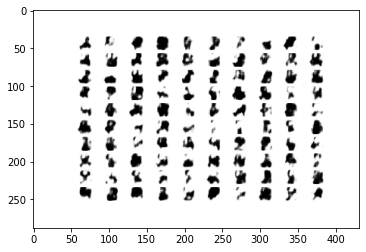

In [40]:
plt.imshow(plt.imread('generated_plot_e001.png'))
plt.show()

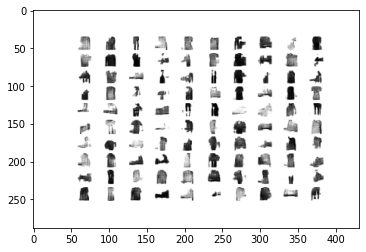

In [41]:
plt.imshow(plt.imread('generated_plot_e010.png'))
plt.show()

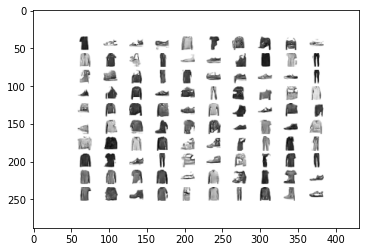

In [42]:
plt.imshow(plt.imread('generated_plot_e100.png'))
plt.show()

Nada mal, ¿verdad? Pero... ¿y si quisiéramos generar solo zapatos? ¿O solo camisetas?

Para ello, necesitamos transformar esta GAN en una GAN condicional o CGAN.

Podéis guiaros con este ejemplo: https://keras.io/examples/generative/conditional_gan/.